In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_palette('deep')

DATA_PATH = "./data/all_hourly_data.h5"

In [2]:
conf_items = {
    "2h set": {
        "sampling_interval": 2,
        "features": ['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation'], 
        "patient_id": "subject_id"
    },
    "4h set": {
        "sampling_interval": 4,
        "features": ['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation'], 
        "patient_id": "subject_id"
    },
    "6h set": {
        "sampling_interval": 6,
        "features": ['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation', 'temperature'],
        "patient_id": "subject_id"
    },
}

In [3]:
def categorize_age(age):
    if age < 30: 
        cat = '<30'
    elif age < 50:
        cat = '30-49'
    elif age < 70:
        cat = '50-69'
    elif age < 90:
        cat = '70-89'
    else: 
        cat = '>90'
    return cat

In [4]:
def load_mimic_hourly_data():
    ''' load hourly measurements and static demogr data'''

    data_vitals = pd.read_hdf(DATA_PATH, 'vitals_labs_mean')
    data_vitals.columns = data_vitals.columns.droplevel('Aggregation Function')

    data_stats = pd.read_hdf(DATA_PATH, 'patients')
    data_stats = data_stats[['age', 'gender', 'admission_type', 'hospital_expire_flag']]
    data_stats.loc[:,'age'] = data_stats['age'].apply(categorize_age)

    return data_vitals.reset_index(), data_stats.reset_index()


In [5]:
def plot_histogram(ax=None, df=None, hue:str=None):
    '''
    Plots seaborn histogram for df separated by hue
    '''
    sns.histplot(df,  x="values", ax=ax, hue=hue)

In [6]:
def resample_data(data: pd.DataFrame=None, interval_h: int = 4, features: list = [], patient_id:str = "subject_id"):
    '''
    Resamples hourly dataset by sampling interval in h, selects features, and drops all patients with any NaN

            Parameters:
                    data (DataFrame): Dataset with NaN, features and patient identifier 
                    features (list): List of features 
                    patient_id (str): Patient identifier column 

            Returns:
                    df (DataFrame): Complete Case Set with resampled mean values
    '''
    # selection of features with patient id
    data = data.loc[:, features + [patient_id], ]
    # setting interval index for groups 
    data['{}h_index'.format(str(interval_h))] = data.groupby([patient_id]).cumcount()//interval_h
    # resample values with mean and keeping outliers 
    data = data.groupby([patient_id, '{}h_index'.format(str(interval_h))]).mean().reset_index()
    # dropping all patients with any NaN in any feature per time index group
    return data.groupby(patient_id).filter(lambda x: x.notna().all().all())

In [7]:
def resample_data_conf_items(conf_items: dict = None, hourly_data: pd.DataFrame = None):
    ''' iterates through item dict and resamples data '''
    for item in conf_items.keys():
        print("resampling dataset ", item)
        config = conf_items[item]
        conf_items[item]["data"] = resample_data(
                                    data=hourly_data, 
                                    interval_h= config["sampling_interval"], 
                                    features=config["features"], 
                                    patient_id=config["patient_id"]
                                )
        conf_items[item]["n_subjects"] = len(conf_items[item]["data"][config["patient_id"]].unique())
    return conf_items

In [8]:
hourly_data, demo_stat = load_mimic_hourly_data()
conf_items = resample_data_conf_items(conf_items, hourly_data)

resampling dataset  2h set
resampling dataset  4h set
resampling dataset  6h set


In [9]:
conf_items.keys()

dict_keys(['2h set', '4h set', '6h set'])

In [10]:
dfs_plotified = [(conf_items[item]["data"].groupby(conf_items[item]["patient_id"])\
    ['{}h_index'.format(str(conf_items[item]["sampling_interval"]))]\
        .count() * conf_items[item]["sampling_interval"])\
            .reset_index(name="seq_lens").assign(sampling=str(conf_items[item]["sampling_interval"])) for item in conf_items.keys()] + \
                [hourly_data.groupby("subject_id").hours_in.count().reset_index(name="seq_lens").assign(sampling="none")]

df_plot = pd.concat(dfs_plotified).reset_index()

In [11]:
df_plot.sampling.unique()

array(['2', '4', '6', 'none'], dtype=object)

In [12]:
df_plot

,index,subject_id,seq_lens,sampling
0,0,49,26,2
1,1,75,30,2
2,2,77,28,2
3,3,84,14,2
4,4,108,26,2
...,...,...,...,...
60646,34467,99983,25,none
60647,34468,99991,76,none
60648,34469,99992,48,none
60649,34470,99995,52,none


<AxesSubplot:xlabel='seq_lens', ylabel='sampling'>

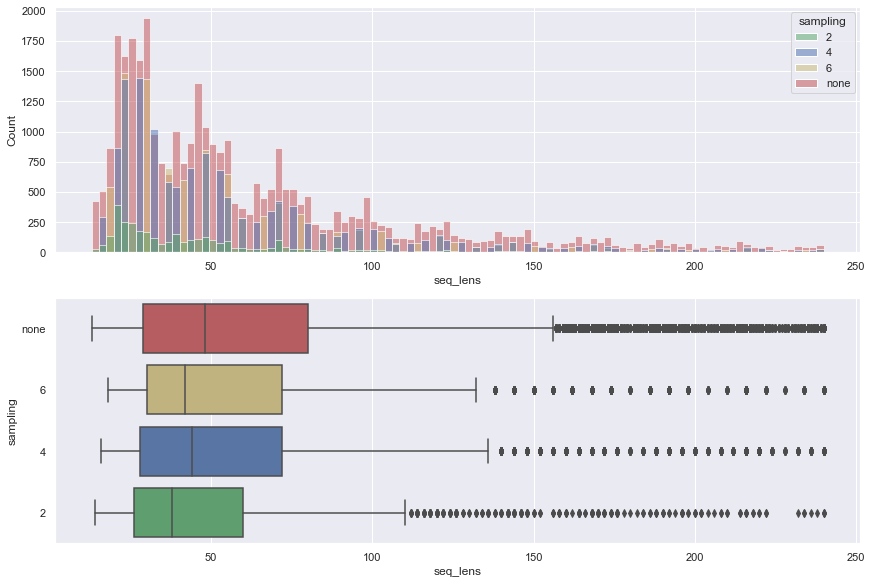

In [40]:
fig = plt.figure(constrained_layout=True, figsize=(12,8))
subf = fig.subfigures(2,1)
ax1 = subf[0].subplots(1,1)
ax2 = subf[1].subplots(1,1)
my_pal = {"2": "g", "4": "b", "6":"y", "none":"r"}
sns.histplot(data=df_plot.sort_values("sampling", ascending=True),  x="seq_lens", ax=ax1, hue="sampling", palette=my_pal, bins=100)
sns.boxplot(data=df_plot.sort_values("sampling", ascending=False),  x="seq_lens", ax=ax2,  y="sampling", palette=my_pal)

In [48]:
df4h = data.loc[:,['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation', 'subject_id'], ]

In [49]:
df4h['4h'] = df4h.groupby(['subject_id']).cumcount()//4

In [53]:
df4h = df4h.groupby(['subject_id', '4h']).mean().reset_index()

In [54]:
df4h

LEVEL2,subject_id,4h,heart rate,systolic blood pressure,diastolic blood pressure,respiratory rate,oxygen saturation
0,3,0,140.937500,95.958333,48.906250,10.937500,90.750000
1,3,1,129.500000,113.500000,67.500000,12.416667,96.000000
2,3,2,106.625000,108.625000,65.125000,6.000000,99.125000
3,3,3,92.111111,98.555556,57.111111,14.244444,92.016667
4,3,4,85.125000,108.250000,61.625000,14.250000,87.333333
...,...,...,...,...,...,...,...
563087,99999,2,96.500000,119.500000,64.000000,19.000000,97.250000
563088,99999,3,96.000000,133.500000,73.500000,19.750000,96.750000
563089,99999,4,95.000000,126.250000,71.500000,18.500000,99.000000
563090,99999,5,87.500000,132.000000,63.250000,18.500000,99.750000


In [55]:
df4h = df4h.groupby('subject_id').filter(lambda x: x.notna().all().all())

In [56]:
df4h

LEVEL2,subject_id,4h,heart rate,systolic blood pressure,diastolic blood pressure,respiratory rate,oxygen saturation
103,11,0,92.00,109.25,51.50,18.750000,96.250000
104,11,1,88.00,105.00,54.25,17.250000,96.250000
105,11,2,85.50,116.25,61.50,20.333333,98.000000
106,11,3,84.75,99.50,52.00,17.750000,96.000000
107,11,4,72.25,94.50,44.25,17.500000,95.666667
...,...,...,...,...,...,...,...
563087,99999,2,96.50,119.50,64.00,19.000000,97.250000
563088,99999,3,96.00,133.50,73.50,19.750000,96.750000
563089,99999,4,95.00,126.25,71.50,18.500000,99.000000
563090,99999,5,87.50,132.00,63.25,18.500000,99.750000


In [ ]:
sns.histplot(origdf[feats[n]], bins=50, ax=axs[n], kde=False )

In [10]:
# hourly distribution of preprocessed data for n=34472 stays and patients
list(data.groupby("hadm_id").hours_in.count())

[103,
 47,
 120,
 99,
 60,
 39,
 86,
 149,
 17,
 95,
 51,
 26,
 49,
 90,
 165,
 23,
 28,
 58,
 45,
 22,
 29,
 29,
 147,
 37,
 42,
 27,
 35,
 119,
 52,
 40,
 21,
 27,
 49,
 43,
 67,
 20,
 37,
 28,
 90,
 26,
 159,
 45,
 70,
 211,
 27,
 40,
 37,
 53,
 46,
 47,
 44,
 74,
 31,
 90,
 18,
 230,
 23,
 37,
 49,
 35,
 74,
 65,
 22,
 76,
 96,
 42,
 157,
 134,
 36,
 62,
 92,
 61,
 24,
 118,
 20,
 73,
 139,
 22,
 28,
 109,
 27,
 69,
 20,
 50,
 113,
 32,
 32,
 99,
 28,
 73,
 21,
 29,
 22,
 47,
 48,
 59,
 87,
 93,
 33,
 114,
 140,
 146,
 80,
 76,
 50,
 17,
 125,
 51,
 28,
 217,
 100,
 96,
 27,
 31,
 62,
 26,
 29,
 62,
 126,
 123,
 37,
 21,
 157,
 97,
 110,
 29,
 101,
 90,
 35,
 26,
 37,
 48,
 26,
 76,
 50,
 56,
 17,
 94,
 85,
 45,
 103,
 28,
 117,
 72,
 22,
 92,
 29,
 26,
 35,
 56,
 99,
 184,
 42,
 22,
 18,
 100,
 49,
 23,
 21,
 17,
 210,
 35,
 18,
 45,
 18,
 155,
 149,
 28,
 27,
 162,
 52,
 61,
 24,
 81,
 24,
 116,
 77,
 28,
 35,
 94,
 71,
 18,
 65,
 25,
 44,
 44,
 36,
 28,
 209,
 45,
 47,
 31,
 64,

In [34]:
len(data.hadm_id.unique())

34472

In [35]:
len(data.icustay_id.unique())

34472

In [36]:
len(data.subject_id.unique())

34472

In [19]:
data_labs.reset_index().head()

LEVEL2,subject_id,hadm_id,icustay_id,hours_in,alanine aminotransferase,albumin,albumin ascites,albumin pleural,albumin urine,alkaline phosphate,...,total protein,total protein urine,troponin-i,troponin-t,venous pvo2,weight,white blood cell count,white blood cell count urine,ph,ph urine
0,3,145834,211552,0,25.0,1.8,NaN,NaN,NaN,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,14.842857,NaN,7.40,5.0
1,3,145834,211552,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,145834,211552,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.26,NaN
3,3,145834,211552,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,145834,211552,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
len(data_labs.hadm_id.unique())

AttributeError: 'DataFrame' object has no attribute 'hadm_id'

In [9]:
data_labs.index = data_labs.index.droplevel(['hadm_id', 'icustay_id'])

In [10]:
data_labs.head()

LEVEL2               alanine aminotransferase albumin albumin ascites  \
Aggregation Function                     mean    mean            mean   
subject_id hours_in                                                     
3          0                             25.0     1.8             NaN   
           1                              NaN     NaN             NaN   
           2                              NaN     NaN             NaN   
           3                              NaN     NaN             NaN   
           4                              NaN     NaN             NaN   

LEVEL2               albumin pleural albumin urine alkaline phosphate  \
Aggregation Function            mean          mean               mean   
subject_id hours_in                                                     
3          0                     NaN           NaN               73.0   
           1                     NaN           NaN                NaN   
           2                     NaN           NaN                NaN   
           3                     NaN           NaN                NaN   
           4                     NaN           NaN                NaN   

LEVEL2                anion gap asparate aminotransferase basophils  \
Aggregation Function       mean                      mean      mean   
subject_id hours_in                                                   
3          0          20.666667                      69.0       NaN   
           1                NaN                       NaN       NaN   
           2                NaN                       NaN       NaN   
           3                NaN                       NaN       NaN   
           4                NaN                       NaN       NaN   

LEVEL2               bicarbonate  ... total protein total protein urine  \
Aggregation Function        mean  ...          mean                mean   
subject_id hours_in               ...                                     
3          0           16.333333  ...           NaN                 NaN   
           1                 NaN  ...           NaN                 NaN   
           2                 NaN  ...           NaN                 NaN   
           3                 NaN  ...           NaN                 NaN   
           4                 NaN  ...           NaN                 NaN   

LEVEL2               troponin-i troponin-t venous pvo2 weight  \
Aggregation Function       mean       mean        mean   mean   
subject_id hours_in                                             
3          0                NaN        NaN         NaN    NaN   
           1                NaN        NaN         NaN    NaN   
           2                NaN        NaN         NaN    NaN   
           3                NaN        NaN         NaN    NaN   
           4                NaN        NaN         NaN    NaN   

LEVEL2               white blood cell count white blood cell count urine  \
Aggregation Function                   mean                         mean   
subject_id hours_in                                                        
3          0                      14.842857                          NaN   
           1                            NaN                          NaN   
           2                            NaN                          NaN   
           3                            NaN                          NaN   
           4                            NaN                          NaN   

LEVEL2                  ph ph urine  
Aggregation Function  mean     mean  
subject_id hours_in                  
3          0          7.40      5.0  
           1           NaN      NaN  
           2          7.26      NaN  
           3           NaN      NaN  
           4           NaN      NaN  

[5 rows x 104 columns]